In [5]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Device setup for MPS (Metal Performance Shaders)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Define the AdvancedTransform class for training
class AdvancedTransform:
    def __init__(self):
        self.common_augmentation = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=1.0),
            A.Affine(
                rotate=(-15, 15),
                translate_percent=(0.1, 0.1),
                scale=(0.8, 1.2),
                shear=10,
                p=0.5
            ),
            A.ElasticTransform(alpha=1.0, sigma=50, p=0.5),
            A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
            A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        ])
        
        self.image_augmentation = A.Compose([
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        ])

    def __call__(self, image, mask):
        seed = random.randint(0, 2**32)
        
        random.seed(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        image = np.array(image)
        mask = np.array(mask)
        
        # Apply transformations
        transformed = self.common_augmentation(image=image, mask=mask)
        image, mask = transformed['image'], transformed['mask']

        image = self.image_augmentation(image=image)['image']

        # Convert numpy array back to PIL image
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)
        
        return transforms.ToTensor()(image), transforms.ToTensor()(mask)

# Define a simple transform class for validation
class SimpleTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

    def __call__(self, image, mask):
        image = self.transform(image)
        mask = self.transform(mask)
        return image, mask

# Define the KvasirSegDataset class
class KvasirSegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image, mask = self.transform(image, mask)
        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)

        return image, mask

# Paths to images and masks
img_dir = '/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/images'
mask_dir = '/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/masks'

# Get image and mask paths
image_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir)]
mask_paths = [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)]

# Split data into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

# Create transform objects
advanced_transform = AdvancedTransform()
simple_transform = SimpleTransform()

# Create datasets with the appropriate transform
train_dataset = KvasirSegDataset(train_image_paths, train_mask_paths, transform=advanced_transform)
val_dataset = KvasirSegDataset(val_image_paths, val_mask_paths, transform=simple_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


Using device: mps


/Users/snirtahasa/anaconda3/lib/python3.11/site-packages/pydantic/main.py:364: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        out = self.sigmoid(out)
        print(f"Channel Attention Map: {out.cpu().detach().numpy()}")
        return out


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=(kernel_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        x = self.sigmoid(x)
        print(f"Spatial Attention Map: {x.cpu().detach().numpy()}")
        return x


# CBAM Module: Combining Channel and Spatial Attention
class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x


# CBAM-Enhanced U-Net Block
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.cbam = CBAM(out_channels)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.cbam(x)
        return x


# U-Net Architecture with CBAM
class UNetCBAM(nn.Module):
    def __init__(self, num_classes):
        super(UNetCBAM, self).__init__()

        # Encoder
        self.enc1 = UNetBlock(3, 64)
        self.enc2 = UNetBlock(64, 128)
        self.enc3 = UNetBlock(128, 256)
        self.enc4 = UNetBlock(256, 512)

        # Decoder
        self.dec4 = UNetBlock(512, 256)
        self.dec3 = UNetBlock(256, 128)
        self.dec2 = UNetBlock(128, 64)

        # Final output layer
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

        # Maxpool for down-sampling
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.maxpool(enc1))
        enc3 = self.enc3(self.maxpool(enc2))
        enc4 = self.enc4(self.maxpool(enc3))

        # Decoder
        dec4 = F.interpolate(self.dec4(enc4), scale_factor=2, mode='bilinear', align_corners=True)
        dec3 = F.interpolate(self.dec3(dec4 + enc3), scale_factor=2, mode='bilinear', align_corners=True)
        dec2 = F.interpolate(self.dec2(dec3 + enc2), scale_factor=2, mode='bilinear', align_corners=True)

        # Final output
        return self.final(dec2 + enc1)


Model with CBAM:
Model with CBAM (CPU for summary):
Channel Attention Map: [[[[0.46286583]]

  [[0.46792984]]

  [[0.5004075 ]]

  [[0.4846626 ]]

  [[0.5120409 ]]

  [[0.4823126 ]]

  [[0.51157117]]

  [[0.5087383 ]]

  [[0.49211204]]

  [[0.484728  ]]

  [[0.49565747]]

  [[0.5142705 ]]

  [[0.5177436 ]]

  [[0.5048876 ]]

  [[0.48605114]]

  [[0.5281581 ]]

  [[0.47249168]]

  [[0.4973012 ]]

  [[0.4671436 ]]

  [[0.5103155 ]]

  [[0.4772291 ]]

  [[0.4847974 ]]

  [[0.51155245]]

  [[0.48605132]]

  [[0.4884026 ]]

  [[0.53244764]]

  [[0.5009446 ]]

  [[0.4993558 ]]

  [[0.47496673]]

  [[0.5072896 ]]

  [[0.5363885 ]]

  [[0.5022977 ]]

  [[0.5439539 ]]

  [[0.4968914 ]]

  [[0.5239781 ]]

  [[0.5080757 ]]

  [[0.5337922 ]]

  [[0.47459382]]

  [[0.51569295]]

  [[0.48254418]]

  [[0.4870895 ]]

  [[0.49944308]]

  [[0.48978463]]

  [[0.5133006 ]]

  [[0.511553  ]]

  [[0.47393453]]

  [[0.4953987 ]]

  [[0.48347187]]

  [[0.50410396]]

  [[0.48580238]]

  [[0.46356913]]

  [[0.5

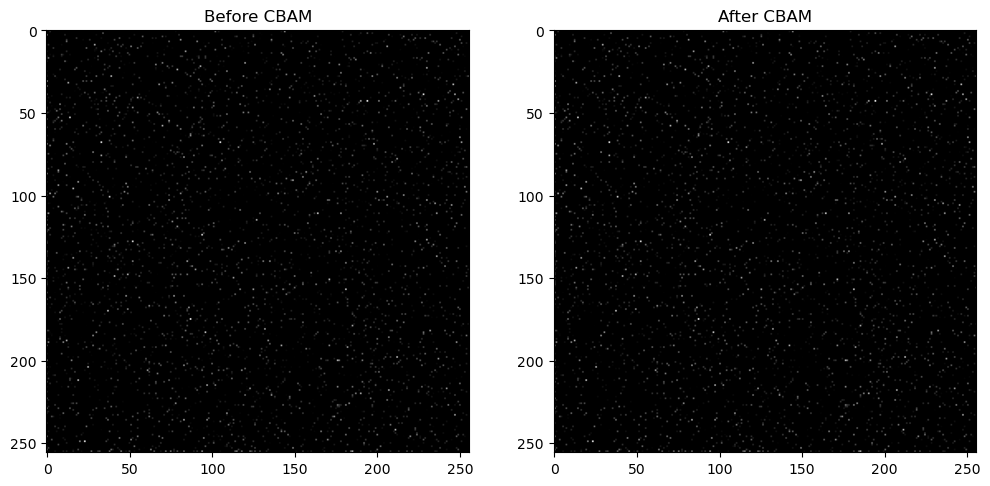

In [11]:
from torchsummary import summary
import matplotlib.pyplot as plt

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Instantiate model with CBAM
model_cbam = UNetCBAM(num_classes=1).to(device)

# Print model summary for clarity
print("Model with CBAM:")
model_cbam_cpu = UNetCBAM(num_classes=1).to("cpu")
print("Model with CBAM (CPU for summary):")
summary(model_cbam_cpu, input_size=(3, 256, 256), device="cpu")

# Visualize feature maps before and after attention
def visualize_feature_maps(model, input_image):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Forward pass up to the first block of the U-Net
        enc1 = model.enc1(input_image.unsqueeze(0))  # Add batch dimension

        # Pass through the CBAM module separately for visualization
        cbam_out = model.enc1.cbam(enc1)

        # Plot original feature maps and after CBAM application
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(enc1[0, 0].cpu(), cmap='gray')
        axs[0].set_title('Before CBAM')
        axs[1].imshow(cbam_out[0, 0].cpu(), cmap='gray')
        axs[1].set_title('After CBAM')
        plt.show()

# Assuming input_image is a random image tensor of shape (3, 256, 256)
input_image = torch.randn(3, 256, 256).to(device)
visualize_feature_maps(model_cbam, input_image)
